In [46]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, gc
import pickle
import datetime, time
from tqdm import tqdm_notebook as tqdm


from sklearn import preprocessing

%matplotlib inline

In [47]:
path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'

In [48]:
os.listdir(path)

['calendar.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'sample_submission.csv']

In [49]:
%%time
train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')

CPU times: user 14 s, sys: 1.7 s, total: 15.7 s
Wall time: 16.5 s


In [50]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [51]:
train_df.store_id.nunique()

10

In [52]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [53]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [54]:
d_cols = [f'd_{i}' for i in range(1,1914)]

In [55]:
data = train_df.set_index('id')[d_cols].T
data.reset_index(drop=True, inplace=True)

In [56]:
calendar_df.date = pd.to_datetime(calendar_df.date)

In [57]:
calendar_df2 = calendar_df[:1913]

In [58]:
data = pd.concat([
    calendar_df2[['date', 'weekday']],
    data
],axis=1)

In [59]:
train_df.store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [60]:
corr_dict = {}
store_id = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
for store in tqdm(store_id):
    tmp_df = data.iloc[-84:,data.columns.str.contains(store)]
    mean = tmp_df.mean(axis=0)
    tmp_df = tmp_df.loc[:,mean>1.5]
    corr_dict[store] = tmp_df.iloc[-84:,tmp_df.columns.str.contains(store)].corr()

In [61]:
with open('corr_dict.pkl', mode='wb') as f:
    pickle.dump(corr_dict, f)

In [62]:
"""
for key, value in corr_dict.items():
    plt.figure(figsize=(30,30))
    sns.heatmap(value, cmap='coolwarm', annot=True)
    plt.show()
"""

"\nfor key, value in corr_dict.items():\n    plt.figure(figsize=(30,30))\n    sns.heatmap(value, cmap='coolwarm', annot=True)\n    plt.show()\n"

In [63]:
corr_dict.keys()

dict_keys(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'])

In [64]:
corr = corr_dict['CA_1']
a = corr[abs(corr)>0.5].isnull().mean(axis=1)
a = a.sort_values()

In [65]:
a.head()

FOODS_3_540_CA_1_validation    0.967192
FOODS_3_147_CA_1_validation    0.971129
FOODS_3_592_CA_1_validation    0.972441
FOODS_3_714_CA_1_validation    0.972441
FOODS_3_618_CA_1_validation    0.973753
dtype: float64

In [66]:
#del train_df, calendar_df
gc.collect()

13237

In [67]:
data2 = data.iloc[:,2:].rolling(70, min_periods=1).sum()
data3 = data.iloc[::-1,2:].rolling(70, min_periods=1).sum()

In [68]:
data3 = data3.iloc[::-1, :]

In [69]:
data2[data2==0]=np.nan
data3[data3==0]=np.nan

In [70]:
data2 = (data2+data3)/2

In [71]:
del data3

In [72]:
data2 = pd.concat([
    data.iloc[:,:2],
    data2
], axis=1)

In [73]:
data3 = data.copy()
data3[data2.isnull()]=np.nan
data2 = data3
del data3

In [74]:
data.head()

,date,weekday,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
0,2011-01-29,Saturday,0,0,0,0,0,0,0,12,...,0,14,1,0,4,0,0,0,0,0
1,2011-01-30,Sunday,0,0,0,0,0,0,0,15,...,0,11,1,0,4,0,0,6,0,0
2,2011-01-31,Monday,0,0,0,0,0,0,0,0,...,0,5,1,0,2,2,0,0,0,0
3,2011-02-01,Tuesday,0,0,0,0,0,0,0,0,...,0,6,1,0,5,2,0,2,0,0
4,2011-02-02,Wednesday,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


In [75]:
data2.head()

,date,weekday,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
0,2011-01-29,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,...,NaN,14.0,1,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1,2011-01-30,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,...,NaN,11.0,1,NaN,4.0,NaN,NaN,6.0,NaN,NaN
2,2011-01-31,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,5.0,1,NaN,2.0,2.0,NaN,0.0,NaN,NaN
3,2011-02-01,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,6.0,1,NaN,5.0,2.0,NaN,2.0,NaN,NaN
4,2011-02-02,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,5.0,1,NaN,2.0,0.0,NaN,2.0,NaN,NaN


In [156]:
tmp_data2 = 
notna_df = data2[data2['HOBBIES_1_003_CA_1_validation'].notnull()][['date','HOBBIES_1_003_CA_1_validation']]
time_diff = notna_df.date.diff().dt.days

In [ ]:
new_df = data2[['date']]
values_list=[]
cols=[]
for col in tqdm(data2.columns[2:]):
        tmp_data2 = data2[col]
        notna_df = data2[data2[col].notnull()][['date', col]]
        time_diff = notna_df.date.diff().dt.days

        tmp=[]
        index_list=[]
        time_diff = time_diff[time_diff>1].index
        if len(time_diff)==0:
            index_list.append([0,2000]) 
        if len(time_diff)==1:
            index_list.append([0,time_diff[0]-1])
            index_list.append([time_diff[0]-1,2000])
        if len(time_diff)>1:
            index_list.append([0,time_diff[0]-1])
            for i in range(len(time_diff)-1):
                index_list.append([time_diff[i]-1, time_diff[i+1]-1])
            index_list.append([time_diff[-1]-1,2000])
            
        data_list=[]
        date_list=[]
        for index in index_list:
            tmp_tmp_data2 = tmp_data2.iloc[index[0]:index[1]]
            if tmp_tmp_data2.sum()==0:
                tmp_tmp_data2 = tmp_tmp_data2.apply(lambda x: np.nan)
            data_list+=tmp_tmp_data2.values.tolist()
        tmp_df = pd.DataFrame(data=data_list)
        tmp_df.index = data2.iloc[tmp_data2.index].date
        tmp_df = tmp_df[0].to_dict()
        values_list.append(tmp_df)
        cols.append(col)

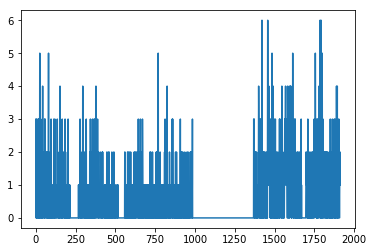

In [204]:
plt.plot(data['HOBBIES_1_282_CA_1_validation'])

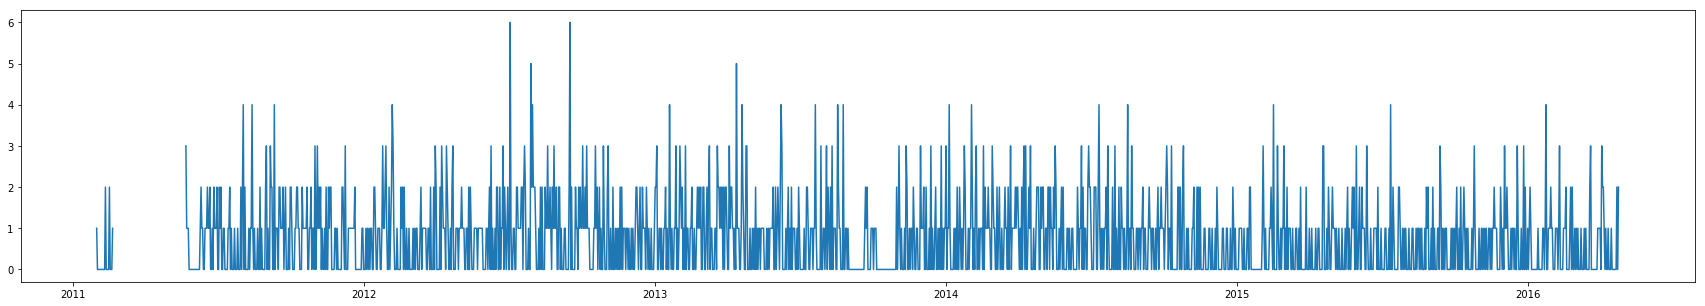

In [244]:
col = 'HOBBIES_1_010_CA_1_validation'
tmp_data2 = data2[col]
notna_df = data2[data2[col].notnull()][['date',col]]
time_diff = notna_df.date.diff().dt.days

tmp=[]
index_list=[]
time_diff = time_diff[time_diff>1].index
if len(time_diff)==0:
    index_list = [0,2000]
if len(time_diff)==1:
    index_list.append([0,time_diff[0]])
    index_list.append([time_diff[1],2000])
if len(time_diff)>1:
    index_list.append([0,time_diff[0]])
    for i in range(len(time_diff)-1):
        index_list.append([time_diff[i], time_diff[i+1]])
    index_list.append([time_diff[-1],2000])
    
tmp_new_df = pd.DataFrame()
for index in index_list:
    tmp_tmp_data2 = tmp_data2.iloc[index[0]:index[1]]
    if tmp_tmp_data2.sum()==0:
        tmp_tmp_data2 = tmp_tmp_data2.apply(lambda x: np.nan)
    tmp_new_df = pd.concat([
        tmp_new_df,
        tmp_tmp_data2
    ], axis=0)
tmp_new_df = pd.concat([
    data2.date[tmp_new_df.index],
    tmp_new_df
],axis=1)
tmp_new_df.columns = ['date', col]

new_df = data2[['date']]
new_df = pd.merge(new_df, tmp_new_df, left_on='date', right_on='date', how='left')

plt.figure(figsize=(30,5))
plt.plot(tmp_new_df.date, tmp_new_df[col])

In [245]:
index_list

[[0, 45], [45, 114], [114, 2000]]

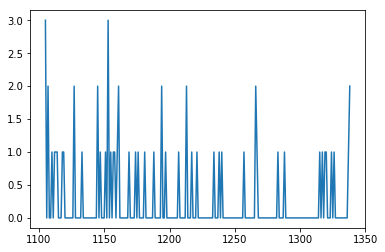

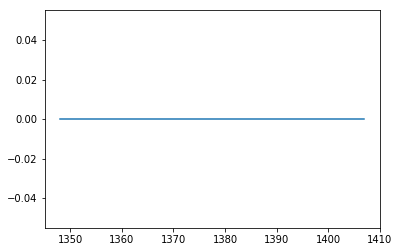

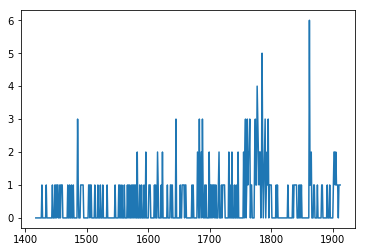

In [155]:
plt.plot(data2['HOBBIES_1_003_CA_1_validation'].iloc[1105:1339])
plt.show()
plt.plot(data2['HOBBIES_1_003_CA_1_validation'].iloc[1348:1408])
plt.show()
plt.plot(data2['HOBBIES_1_003_CA_1_validation'].iloc[1417:1913])
plt.show()

In [76]:
corr_dict.keys()

dict_keys(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'])

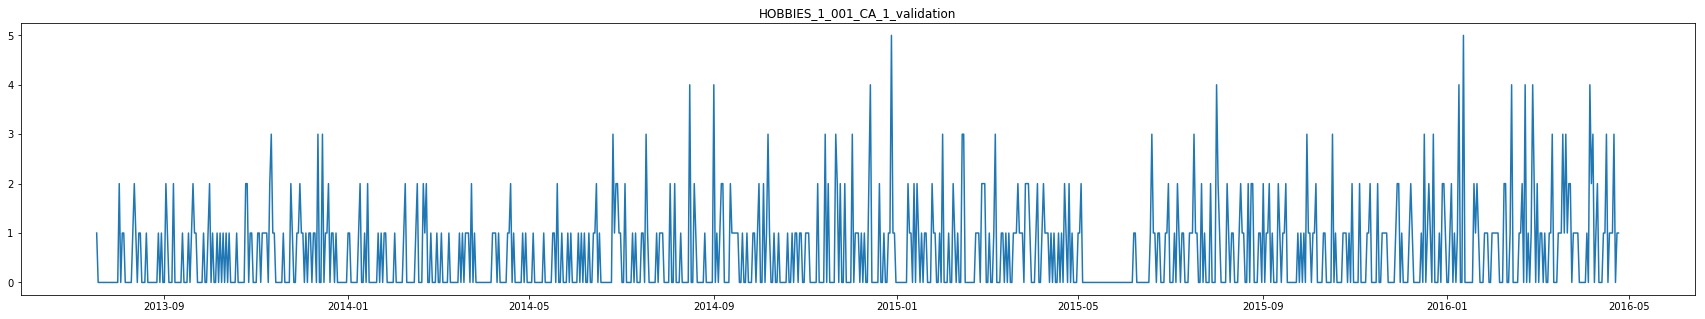

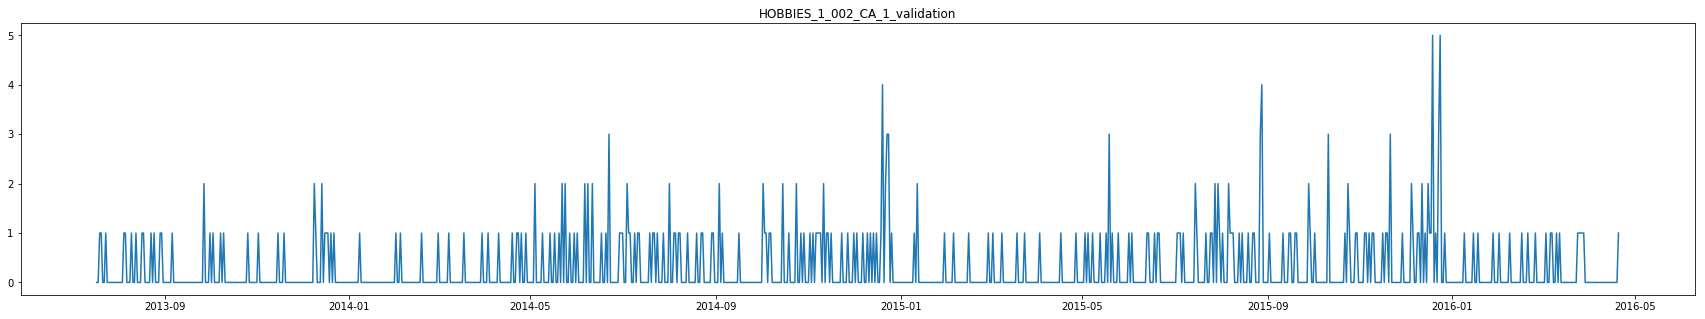

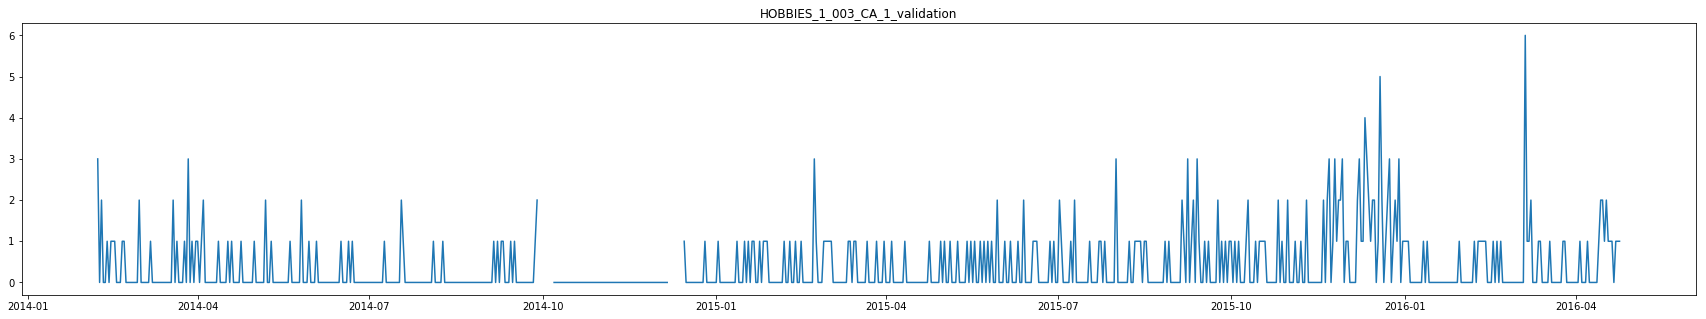

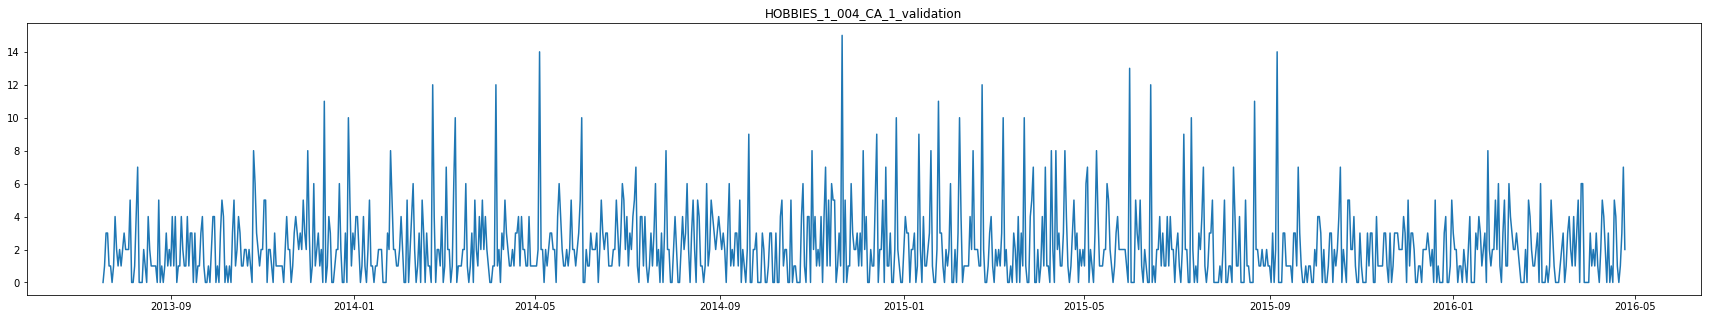

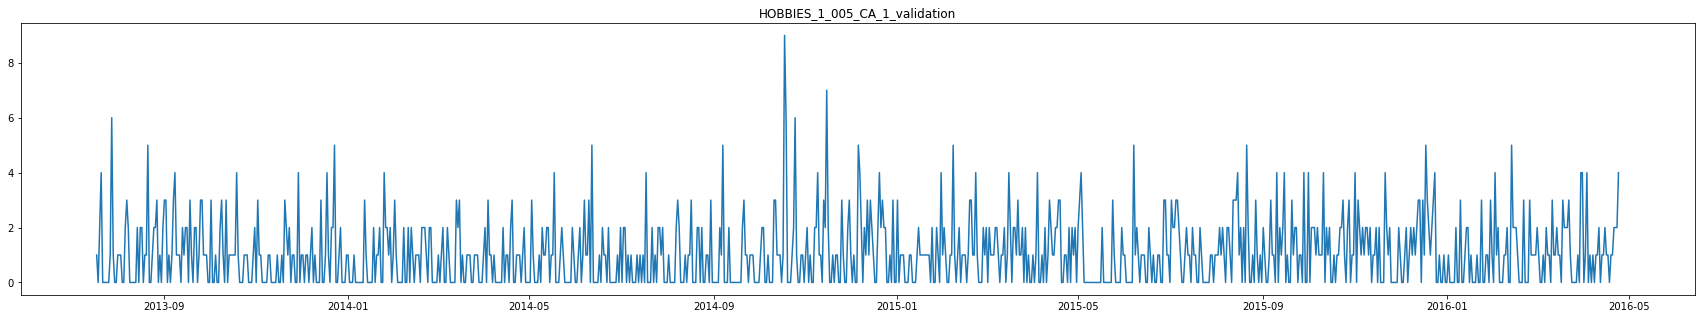

In [135]:
for col in data2.columns[2:7]:
    plt.figure(figsize=(30,5))
    tmp=data2[data2.HOBBIES_1_001_CA_1_validation.notna()][['date', col]]
    plt.plot(tmp.date.values, tmp[col].values)
    plt.title(col)
    plt.show()

In [230]:
data

,date,weekday,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
0,2011-01-29,Saturday,0,0,0,0,0,0,0,12,...,0,14,1,0,4,0,0,0,0,0
1,2011-01-30,Sunday,0,0,0,0,0,0,0,15,...,0,11,1,0,4,0,0,6,0,0
2,2011-01-31,Monday,0,0,0,0,0,0,0,0,...,0,5,1,0,2,2,0,0,0,0
3,2011-02-01,Tuesday,0,0,0,0,0,0,0,0,...,0,6,1,0,5,2,0,2,0,0
4,2011-02-02,Wednesday,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
5,2011-02-03,Thursday,0,0,0,0,0,0,0,4,...,0,13,2,0,7,3,5,4,0,0
6,2011-02-04,Friday,0,0,0,0,0,0,0,6,...,0,18,1,0,8,1,0,1,0,0
7,2011-02-05,Saturday,0,0,0,0,0,0,0,5,...,0,13,3,0,4,4,1,8,0,0
8,2011-02-06,Sunday,0,0,0,0,0,0,0,7,...,0,18,4,0,4,1,1,5,0,0
9,2011-02-07,Monday,0,0,0,0,0,0,0,0,...,0,19,1,0,1,0,3,2,0,0
